本测试将使用 [华夏沪深300ETF(510330)](https://gu.qq.com/sh510330) 对 **周内效应** 进行验证。

> 周内效应：http://erj.cn/UploadFiles/%E4%B8%AD%E5%9B%BD%E8%82%A1%E7%A5%A8%E5%B8%82%E5%9C%BA%E7%9A%84_%E5%91%A8%E5%86%85%E6%95%88%E5%BA%94_.pdf

> 规则说明及其他说明参考 [ETF-周内效应-510310](ETF-周内效应-510310.ipynb)。

验证时对应基准采用沪深300指数(000300)

### 结论

无论是否跑赢基准还是盈利的可能性来说，均低于预期。周内效应对于这个ETF来说不是一个很好的策略:



In [1]:
import logging
logging.disable(logging.INFO)

import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt
import seaborn as sns
from gquant.backtest import backtest
from gquant.week_effect import *

plt.style.use('ggplot')

you are using non-interactive mdoel quantaxis
提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改


In [2]:
CODE='510330' #计算数据
BENCHMARK_CODE='399300' #基准代码（沪深300指数）
START='2012-12-25'
END=QA.QAUtil.QADate.QA_util_today_str()#数据截止到今天。后面会根据不同的测试时间段对数据分段
INIT_CASH=10000#验证时的模拟初始资金
DEFAULT_MA=20#判断上涨/下跌市的SMA取值

In [3]:
def get_data(code=CODE,start=START,end=END,ma=DEFAULT_MA,dropna=True):
    """获取指数数据
    
    Args:
        code: 指数代码
        start: 数据开始时间
        end: 数据截止时间
        ma: 计算SMA时的时间段
    """
    data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    # 收盘价变化率
    data['收盘价变化率'] = data['close'].pct_change()
    data['date'] = data.index.get_level_values(0)
    data['date'] = pd.to_datetime(data['date'])
    # 星期一为0，星期天为6
    data['weekday'] = data['date'].dt.weekday
    # 明天星期
    data['nextday']=data['weekday'].shift(-1)
    # 昨天星期
    data['prevday']=data['weekday'].shift()
    # 简单移动均线
    data["MA"] = QA.QA_indicator_MA(data, ma)
    # 每日成交均价
    data['avg_price']=(data['close']+data['open']+data['high']+data['low'])/4
    # 每日价格变化幅度（收盘价/开盘价）
    data['日价格变化幅度']=data['close']/data['open']-1
    # TR:输出TR:(最高价-最低价)和昨收-最高价的绝对值的较大值和昨收-最低价的绝对值的较大值
    data['TR'] = TR(data)
    # 每日成交均价变化率
    data['日成交均价变化率'] = data['avg_price'].pct_change()
    # 上涨市
    data['market']=np.NaN
    data.loc[data['close']>data["MA"],'market']=1
    # 下跌市
    data['down']=False
    data.loc[data['close']<data["MA"],'market']=-1
    # 昨天是上涨市/下跌市
    data['prev_market']=data['market'].shift()

    if dropna:
        data.dropna(inplace=True)
    return data

In [4]:
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from itertools import product
import datetime

def report_plot(report):
    # https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
    pie_colors=['orangered','silver']
    
    def _plot_pie(data,ax,title):
        data.value_counts().plot(kind='pie',ax=ax,autopct='%1.2f%%',label='',colors=pie_colors,textprops={'color':'w','size':14,'name':'reithsans'})
        ax.set_title(title)
    def _plot_kde(data,ax,title):
        sns.distplot(data,ax=ax)
        ax.set_title(title,size=12)
    
    def _plot_regplot(data,ax,title):
        lm=sns.regplot(data=report[(report.index==v)], x="test_days", y="策略-基准盈亏",ax=ax,color='silver',line_kws={'color':'orangered'})
        ax.set_title(title)
    
    fig = plt.figure(figsize=(16,24),constrained_layout=True)
    gs = GridSpec(8, 4, figure=fig)
    
    report['策略-基准盈亏']=report['策略浮动盈亏']-report['基准浮动盈亏']
    for i,index in enumerate(list(product(['跑赢基准','是否盈利'],['完整','拆分']))):
        _plot_pie(report.loc[index[1],index[0]],fig.add_subplot(gs[i, 0]),'{}-{}'.format(index[0],index[1]))
        for j,year in enumerate([1,2,3]):
            _plot_pie(report[(report.index==index[1])&(report.passyears==year)][index[0]],fig.add_subplot(gs[i, j+1]),'{}-{}-{}年'.format(index[0],index[1],year))
    
    for i,v in enumerate(['完整','拆分']):
        _plot_kde(report[(report.index==v)]['策略-基准盈亏'],fig.add_subplot(gs[4+i, 0]),'策略-基准盈亏-{}-统算'.format(v))
        for j,y in enumerate([1,2,3]):
            _plot_kde(report[(report.index==v)&(report.passyears==y)]['策略-基准盈亏'],fig.add_subplot(gs[4+i, 1+j]),'策略-基准盈亏-{}-{}年'.format(v,y))
            
    for i,v in enumerate(['完整','拆分']):
        _plot_regplot(report[(report.index==v)]['策略-基准盈亏'],fig.add_subplot(gs[6+i, 0]),'策略-基准盈亏-{}-统算'.format(v))
        for j,y in enumerate([1,2,3]):
            _plot_regplot(report[(report.index==v)&(report.passyears==y)]['策略-基准盈亏'],fig.add_subplot(gs[6+i, 1+j]),'策略-基准盈亏-{}-{}年'.format(v,y))
            
            
    fig.suptitle('{}次循环'.format(report.shape[0]/2),size='20')
    plt.show()

### 100万次

> 数据来源：通过脚本执行的结果，保存在Result_510330.7z中，解压缩后使用。

In [5]:
import os
report = pd.concat([pd.read_csv(f) for f in os.listdir() if 'Result_510330' in f]).set_index('name').drop_duplicates()
report['策略-基准盈亏']=report['策略浮动盈亏']-report['基准浮动盈亏']

In [6]:
report.groupby('name')['策略-基准盈亏'].describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
完整,1122310.0,-0.0058,0.0975,-0.4271,-0.0636,-0.0190,0.0404,0.3350
拆分,1093524.0,-0.0132,0.1127,-0.4365,-0.0851,-0.0394,0.0320,0.5765


In [7]:
report.groupby('name')['基准最大回撤','策略最大回撤'].agg(['mean','median'])

基准最大回撤          策略最大回撤        
        mean  median    mean  median
name                                
完整   -0.1654 -0.1311 -0.1236 -0.0880
拆分   -0.1657 -0.1311 -0.1129 -0.0952

In [8]:
import matplotlib.ticker as mtick
win_rate = report.groupby(
    ['name', 'passyears'])['跑赢基准'].value_counts(normalize=True).to_frame()
win_rate = win_rate[win_rate.index.get_level_values(2) == 1]
win_rate.index = win_rate.index.droplevel(2)
win_rate

跑赢基准
name passyears        
完整   1          0.3572
     2          0.3820
     3          0.4789
拆分   1          0.2649
     2          0.3163
     3          0.4066

Text(0.5, 1.0, '拆分/完整 跑赢基准的可能性')

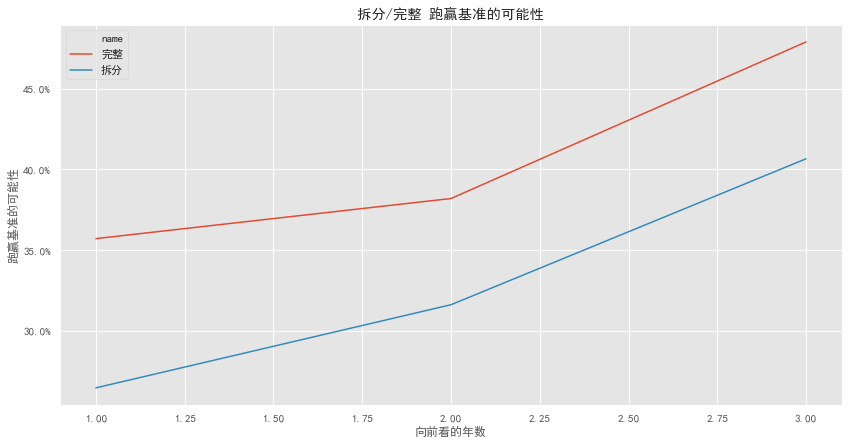

In [9]:
win_rate.reset_index(inplace=True)
ax = sns.lineplot(data=win_rate, x="passyears", y="跑赢基准", hue="name")
ax.set_ylabel('跑赢基准的可能性')
ax.set_xlabel('向前看的年数')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title("拆分/完整 跑赢基准的可能性")

findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.


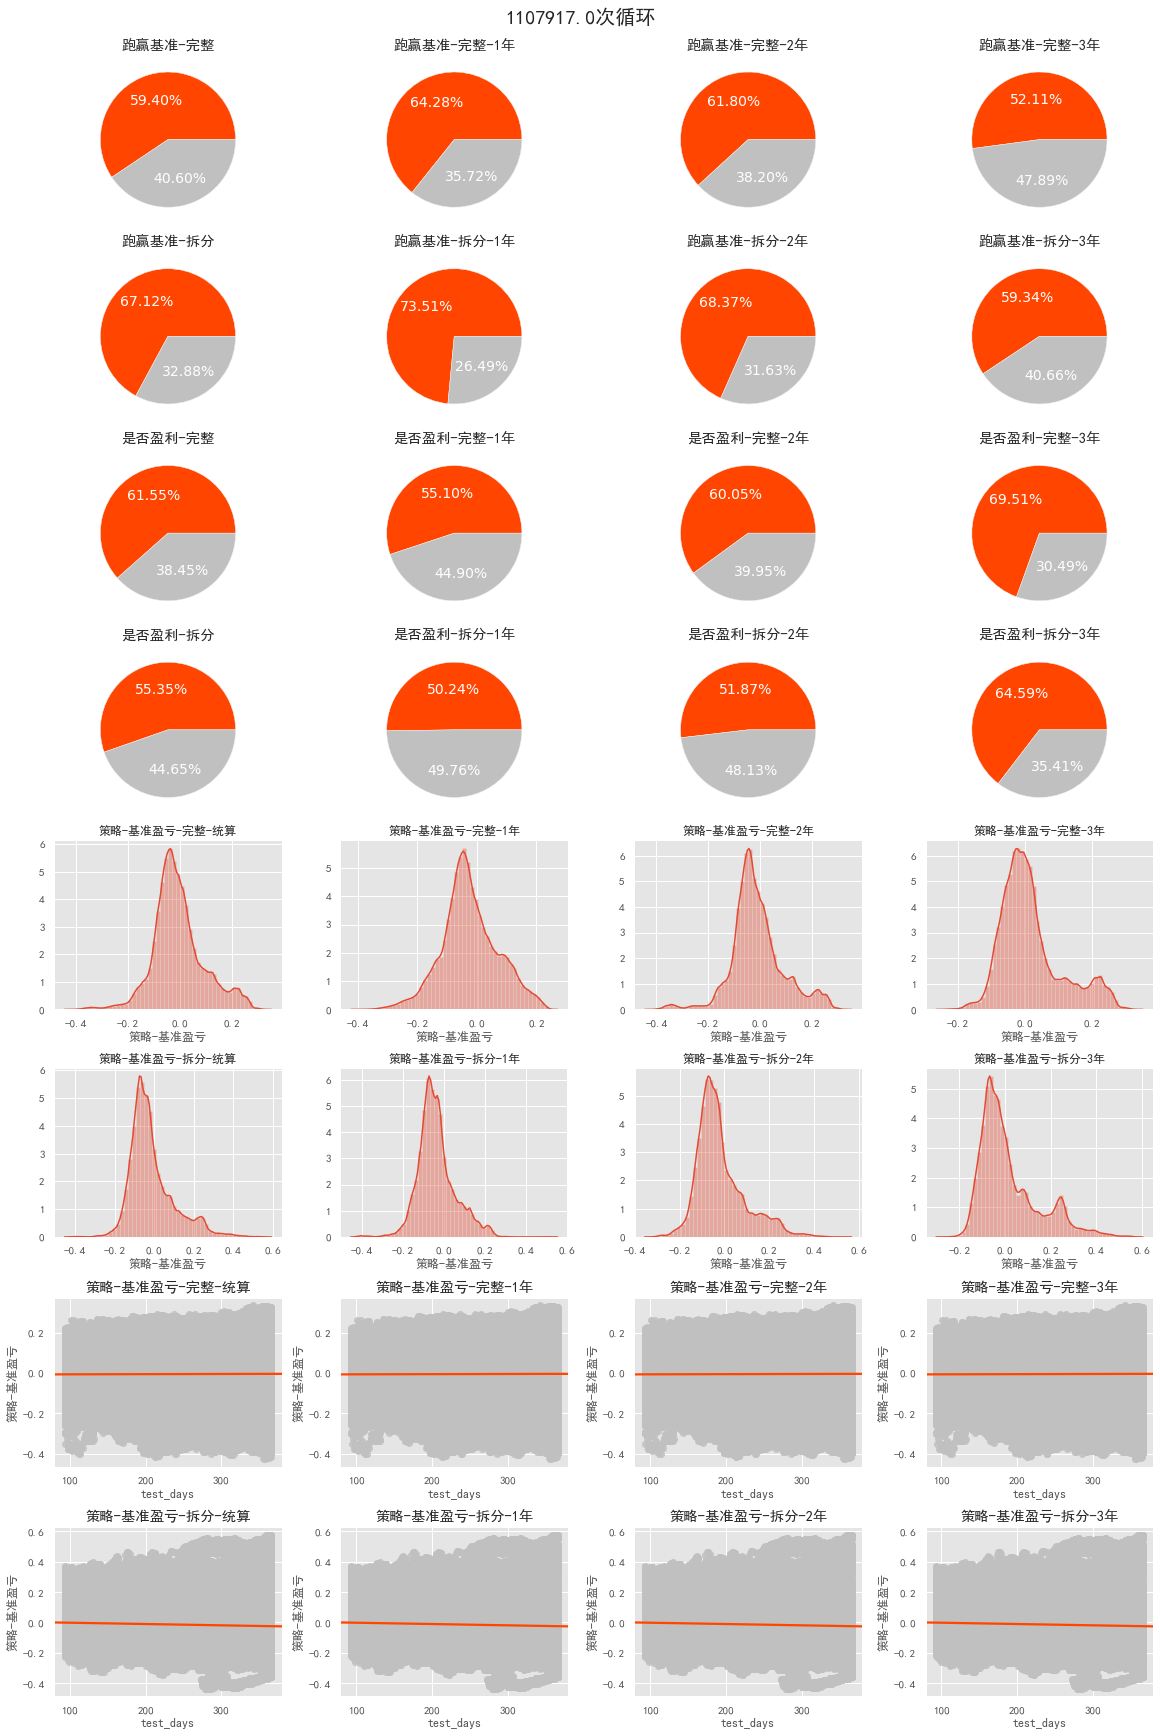

In [10]:
from IPython.display import clear_output
clear_output(wait=True)
report_plot(report)